# 1.2 Visualize the Optimization Process

## Import libraries

In [3]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

/tmp/ipykernel_3635828/2653462923.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [5]:
torch.cuda.is_available()

True

## Define and Plot Function

In [6]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

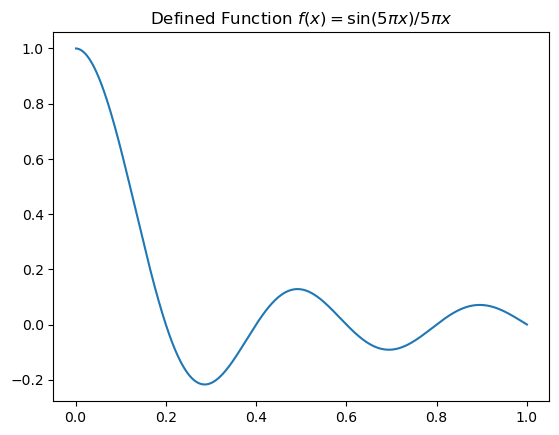

In [7]:
### Plot fn
xvec = torch.linspace(0,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.savefig("grad_fn_2_sim.png")
plt.show()

## Load Data

In [8]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


## View Image

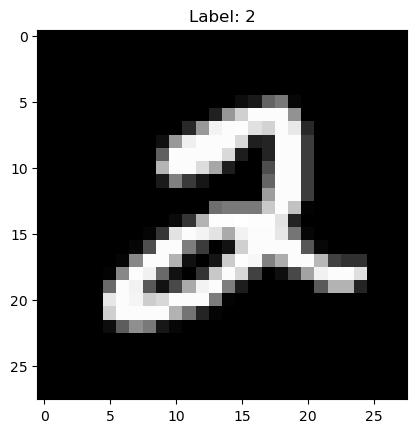

In [9]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Define Model Class

In [10]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
class model_class_fn(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class_fn, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        for layer in self.layers:
            x = layer(x)
        return x

## Train & Eval Function
### With collecting model params

In [12]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # load model to GPU
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    model_weights = pd.DataFrame()
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        print(f"train loss: {train_loss}")

        # Collect parameters
        #weights = [p.data.clone() for p in model.parameters()]
        temp_wts = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().cpu().numpy()
                temp_wts = pd.concat([temp_wts, pd.DataFrame(weights).T], axis = 1)
        model_weights = pd.concat([model_weights,temp_wts], axis = 0)
        
        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        #print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, model_weights

## Specify Model

In [13]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

## Train Model

In [14]:
#m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
#                             , test_loader=test_loader)

In [15]:
##m1_weights.head()
#wts = np.array(m1_weights)

In [16]:
# check model parameter number
model1_parameters = []
for name, param in model1.named_parameters():
    if 'weight' in name:
        model1_parameters.append(param.T.shape[0])
print(model1_parameters)
sum = 0
for l in range(0,len(model1_parameters)-1):
    sum += model1_parameters[l] * model1_parameters[l+1]
sum += model1_parameters[-1]*10 # last output layer
print(sum)

[784, 17, 26, 25, 23, 12]
15391


In [17]:
'''df_temp = m1_weights.copy()
df_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])
df_temp['accuracy'] = m1_acc
df_temp.head()'''

"df_temp = m1_weights.copy()\ndf_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])\ndf_temp['accuracy'] = m1_acc\ndf_temp.head()"

In [18]:
df = pd.DataFrame()
for i in range(8):
    model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])
    m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=30, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)
    df_temp = m1_weights.copy()
    df_temp['loss'] = np.array([x.detach().cpu().numpy() for x in m1_loss])
    df_temp['accuracy'] = m1_acc
    df = pd.concat([df, df_temp], axis = 0).reset_index(drop = True)
df.head()

train loss: 0.7141950130462646
train loss: 0.3187577724456787
train loss: 0.25290167331695557
train loss: 0.2239789515733719
train loss: 0.2024700939655304
train loss: 0.18666554987430573
train loss: 0.1746247112751007
train loss: 0.16394338011741638
train loss: 0.15453964471817017
train loss: 0.14591722190380096
train loss: 0.1395716518163681
train loss: 0.13399988412857056
train loss: 0.12795327603816986
train loss: 0.12135560810565948
train loss: 0.11798600852489471
train loss: 0.11257006227970123
train loss: 0.10903812199831009
train loss: 0.10418666899204254
train loss: 0.10200212150812149
train loss: 0.10055408626794815
train loss: 0.09759920090436935
train loss: 0.09558618068695068
train loss: 0.09148722141981125
train loss: 0.08829965442419052
train loss: 0.08860819786787033
train loss: 0.0857047364115715
train loss: 0.0847187340259552
train loss: 0.08103329688310623
train loss: 0.08053714781999588
train loss: 0.07966280728578568
train loss: 0.6608695387840271
train loss: 0.312

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,loss,accuracy
0,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.114188,0.060838,0.083112,-0.449328,-0.156858,0.119905,-0.109977,-0.020357,0.714195,89.76
1,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.114188,0.069057,0.090229,-0.510643,-0.120833,0.113105,-0.127762,-0.020357,0.318758,92.33
2,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.114188,0.074882,0.135281,-0.506355,-0.090672,0.125434,-0.131536,-0.020357,0.252902,93.34
3,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.114188,0.072053,0.137491,-0.487593,-0.090677,0.131060,-0.135157,-0.162964,0.223979,93.68
4,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.114188,0.070525,0.138206,-0.467182,-0.091002,0.141053,-0.137426,-0.162965,0.202470,94.11


Add Accuracy and Loss columns to the weights data frame.

## PCA

In [19]:
df_pca = df.drop(["loss", "accuracy"], axis = 1).reset_index(drop = True)
print(df_pca.shape)
df_pca.head()

(240, 15391)


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,0.248372,-0.354204,-0.114188,0.060838,0.083112,-0.449328,-0.156858,0.119905,-0.109977,-0.020357
1,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,0.268250,-0.312169,-0.114188,0.069057,0.090229,-0.510643,-0.120833,0.113105,-0.127762,-0.020357
2,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,0.299171,-0.307136,-0.114188,0.074882,0.135281,-0.506355,-0.090672,0.125434,-0.131536,-0.020357
3,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,0.313429,-0.312431,-0.114188,0.072053,0.137491,-0.487593,-0.090677,0.131060,-0.135157,-0.162964
4,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,0.336008,-0.338538,-0.114188,0.070525,0.138206,-0.467182,-0.091002,0.141053,-0.137426,-0.162965


In [20]:
df_pca = np.array(df_pca)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df_pca)

In [21]:

df_full = pd.DataFrame(new_data, columns=['x','y'])
df_full['Accuracy'] = df['accuracy'].reset_index(drop = True)
df_full['Loss'] = df['loss'].reset_index(drop = True)
#df_full.head()
df_full = df_full.iloc[::3, :]

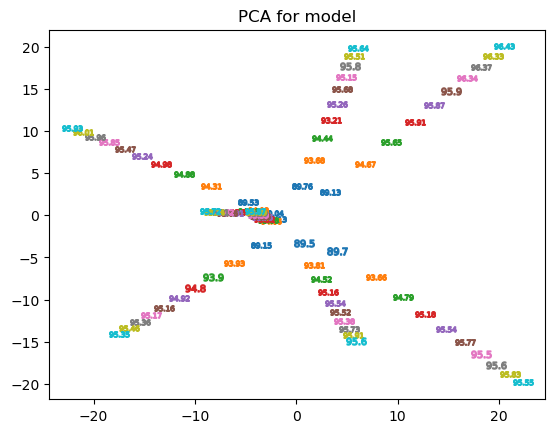

In [33]:
for i in range(80):
    m = list(df_full['Accuracy'])[i]
    plt.scatter(df_full['x'][i*3], df_full['y'][i*3], s = 200, marker = f'${m}$')
    plt.title("PCA for model")
plt.savefig("PCA_model.png")
plt.show()

### Layer 1

In [23]:
df_pca = df.drop(["loss", "accuracy"], axis = 1).reset_index(drop = True)
layer_1 = df_pca.iloc[ : , 0:13328]
layer_1.head()

,0,1,2,3,4,5,6,7,8,9,...,13318,13319,13320,13321,13322,13323,13324,13325,13326,13327
0,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.135435,-0.121291,0.013109,-0.052040,-0.058427,-0.041295,-0.021944,-0.009084,-0.020024,-0.020533
1,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.164333,-0.186568,0.003544,-0.101643,-0.092642,-0.074932,-0.021944,-0.009084,-0.020024,-0.020533
2,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.179335,-0.240740,-0.001397,-0.133998,-0.123753,-0.109997,-0.021944,-0.009084,-0.020024,-0.020533
3,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.175368,-0.218442,0.031351,-0.148600,-0.139516,-0.148569,-0.021944,-0.009084,-0.020024,-0.020533
4,0.024366,0.017267,0.001255,0.030053,0.031602,-0.02263,-0.020875,-0.012234,-0.010021,-0.005438,...,-0.177838,-0.230639,-0.004072,-0.197111,-0.145687,-0.168173,-0.021944,-0.009084,-0.020024,-0.020533


In [24]:
new_data = pca.fit_transform(df_pca)
df_l1 = pd.DataFrame(new_data, columns=['x','y'])
df_l1['Accuracy'] = df['accuracy'].reset_index(drop = True)
df_l1['Loss'] = df['loss'].reset_index(drop = True)
#df_full.head()
df_l1 = df_l1.iloc[::3, :]

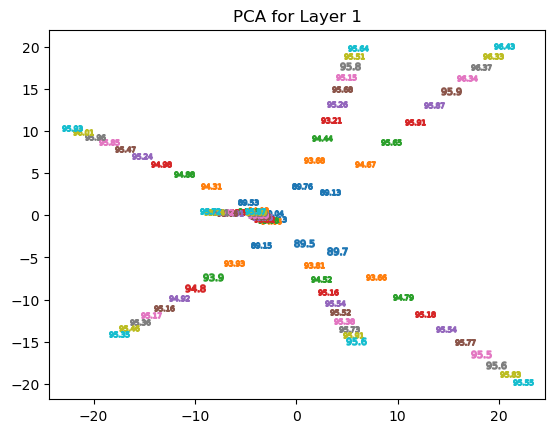

In [34]:
for i in range(80):
    m = list(df_l1['Accuracy'])[i]
    plt.scatter(df_l1['x'][i*3], df_l1['y'][i*3], s = 200, marker = f'${m}$')
    plt.title("PCA for Layer 1")
plt.savefig("PCA_layer1.png")
plt.show()

## Gradient Norm

In [26]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

## Train & Eval Function
### With gradient norm function

In [27]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # model to device
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    gradient = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        gradient.append(gradient_norm(model))
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}; loss: {train_loss}")
    return total_loss, gradient

In [28]:
 ### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):

  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      epoch_loss = epoch_loss/len(data_loader.sampler)
      if epoch % 100 == 0:
         print(f"Epoch: {epoch}; loss: {epoch_loss}")
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
  return loss_vec, gradient

In [31]:
### Train on fn(x)
model1 = model_class_fn(input_size = 1, output_size = 1, hidden_sizes = [17, 26, 25, 23, 12])
x_train = torch.linspace(0.1,1,2000).unsqueeze(1)
y_train = fn(x_train)
# Train the model
model1_loss, model1_grad = train_model(model1, x_train, y_train, batch = 50, epochs = 1000, learning_rate = 0.001)

Epoch: 0; loss: 0.000745955974329263
Epoch: 100; loss: 1.1529724054071267e-07
Epoch: 200; loss: 1.40158574652105e-07
Epoch: 300; loss: 6.064131946459384e-08
Epoch: 400; loss: 1.5858792619383167e-07
Epoch: 500; loss: 4.217001560391509e-08
Epoch: 600; loss: 3.7471334763949926e-08
Epoch: 700; loss: 1.5333022190588964e-08
Epoch: 800; loss: 3.8476917040952684e-08
Epoch: 900; loss: 2.7426447303469105e-08


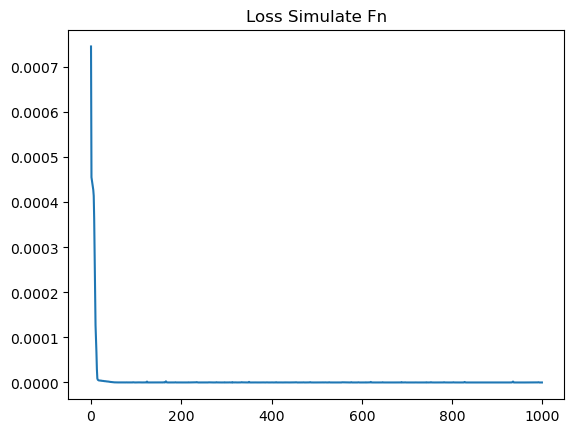

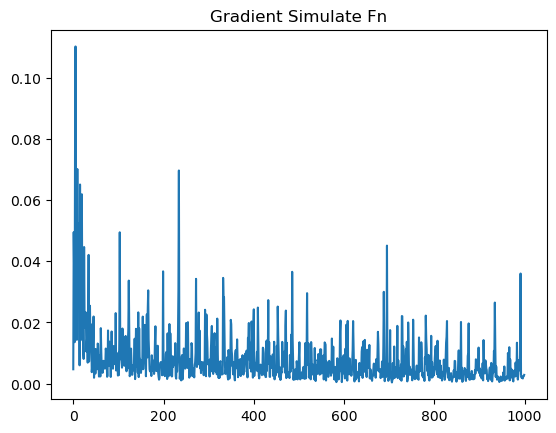

In [32]:
plt.plot(np.arange(0, len(model1_loss)), model1_loss)
plt.title("Loss Simulate Fn")
plt.savefig("grad_norm_loss_fn.png")
plt.show()
plt.plot(np.arange(0, len(model1_grad)), model1_grad)
plt.title("Gradient Simulate Fn")
plt.savefig("grad_norm_fn.png")
plt.show()